# Tabu Search (Travelling Salesman)

In [1]:
from math import dist
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

### X and Y coordinates for different graphs

In [2]:
x1 = [0.09 , 0.16 , 0.84 , 0.70]
y1 = [0.17,   0.52,  0.92, 0.16]

x2 = [16.47000,16.47000,20.09000,22.39000,25.23000,22,20.47000,17.20000,16.30000,14.05000,16.53000,21.52000,19.41000,20.09000]
y2 = [96.10000,94.44000,92.54000,93.37000,97.24000,96.05000,97.02000,96.29000,97.38000,98.12000,97.38000,95.59000,97.13000,94.55000]

x3 = [7,9,2,0,0,1,7,1,2,51,42,31,5,12,36,52,27,17,13,57,62,42,16,8,7,27,30,43,58,58,37,38,46,61,62,63,32,45,59,5,10,21,5,30,39,32,25,25,48,56]
y3 = [52,49,64,26,30,47,63,62,33,21,41,32,25,42,16,41,23,33,13,58,42,57,57,52,38,68,48,67,48,27,69,46,10,33,63,69,22,35,15,6,17,10,64,15,10,39,32,55,28,37]

x4 = [1380,2848,3510,457,3888,984,2721,1286,2716,738,1251,2728,3815,3683,1247,123,1234,252,611,2576,928,53,1807,274,2574,178,2678,1795,3384,3520,1256,1424,3913,3085,2573,463,3875,298,3479,2542,3955,1323,3447,2936,1621,3373,1393,3874,938,3022,2482,3854,376,2519,2945,953,2628,2097,890,2139,2421,2290,1115,2588,327,241,1917,2991,2573,19,3911,872,2863,929,839,3893,2178,3822,378,1178,2599,3416,2961,611,3113,2597,2586,161,1429,742,1625,1187,1787,22,3640,3756,776,1724,198,3950]
y4 = [939,96,1671,334,666,965,1482,525,1432,1325,1832,1698,169,1533,1945,862,1946,1240,673,1676,1700,857,1711,1420,946,24,1825,962,1498,1079,61,1728,192,1528,1969,1670,598,1513,821,236,1743,280,1830,337,1830,1646,1368,1318,955,474,1183,923,825,135,1622,268,1479,981,1846,1806,1007,1810,1052,302,265,341,687,792,599,674,1673,1559,558,1766,620,102,1619,899,1048,100,901,143,1605,1384,885,1830,1286,906,134,1025,1651,706,1009,987,43,882,392,1642,1810,1558]

## Creating a graph

In [3]:
class Graph:
    def __init__(self, x, y) -> None:
        self.n = n = len(x)
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.edges = np.zeros(shape=(n,n), dtype=float)

        for i in range(self.n):
            for j in range(self.n):
                self.edges[i,j] = dist([x[i], y[i]], [x[j], y[j]])

## Make a set of plots for visualization before and after optimization

In [4]:
def make_plots(costs, tour, graph):
  fig, ax =  plt.subplots(1, 2, figsize=(11, 5))

  # second plot, for cost vs iteration
  ax[0].set_ylabel('Value of best_ant.cost')
  ax[0].set_xlabel('Iteration #')
  ax[0].plot(costs)

  # third plot, for tour after optimization
  plot_x = []
  plot_y = []
  for i in tour:
      plot_x.append(graph.x[i])
      plot_y.append(graph.y[i])
  plot_x.append(graph.x[tour[0]])
  plot_y.append(graph.y[tour[0]])

  ax[1].set_ylabel('Y')
  ax[1].set_xlabel('X')
  ax[1].plot(plot_x, plot_y, marker='o', color='green', linestyle='dashed')

## Defining the objective funtion

In [5]:
def objective(tour, graph):
    fitn = 0
    n = len(tour)
    for i in range(n-1):
        fitn += graph.edges[tour[i], tour[i+1]]

    fitn += graph.edges[tour[0], tour[-1]]
    return fitn

## Creating the colony

In [6]:
class Ant:
    def __init__(self) -> None:
        self.tour = []
        self.cost = np.inf

    def __repr__(self) -> str:
        return f'Ant(tour={self.tour}, o={self.cost})'

    def __lt__(self, other):
        return self.cost < other.cost

class Colony:
    def __init__(self, graph, n_ants, tau, eta, alpha, beta) -> None:
        self.n_vertex = n = graph.n
        self.n_ants = n_ants
        self.ants = [Ant() for i in range(n_ants)]

        for i in range(n_ants):
            self.ants[i].tour.append(np.random.randint(n))
            for j in range(1, n):
                last = self.ants[i].tour[-1]
                probs = (tau[last] ** alpha) * (eta[last] ** beta)
                probs[self.ants[i].tour] = 0
                probs = probs / np.sum(probs)
                self.ants[i].tour.append(np.random.choice(n, p=probs))

        for i in range(n_ants):
            self.ants[i].cost = objective(self.ants[i].tour, graph)

        self.queen = copy.deepcopy(min(self.ants))

## Function to update pheromones

In [7]:
def update_pheromones(colony, tau):
    n_ants = colony.n_ants
    n_vertex = colony.n_vertex

    for i in range(n_ants):
        for j in range(n_vertex - 1):
            cur, nxt = colony.ants[i].tour[j:j+2]
            tau[cur][nxt] += 1/colony.ants[i].cost
            tau[nxt][cur] += 1/colony.ants[i].cost

## Function to implement ACO

In [8]:
def run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta):

    best_ant = Ant()
    costs = []
    # taus = []

    for t in tqdm(range(max_iter)):
        # if t % 10 == 0:
        #     taus.append(np.max(tau, axis=1))
        colony = Colony(graph, n_ants, tau, eta, alpha, beta)
        best_ant = copy.deepcopy(min(best_ant, colony.queen))
        update_pheromones(colony, tau)
        tau = (1-rho) * tau

        costs.append(best_ant.cost)
    # sns.heatmap(taus)
    return best_ant, costs

## Graph 1

In [9]:
# objective([0,1,2,3], graph)

In [10]:
# graph = Graph(x1, y1)

# # creating eta matrix
# with np.errstate(divide='ignore',invalid='ignore'):
#     eta = 1/graph.edges
# eta[eta == np.inf] = 0

# # creating tau matrix
# tau = np.full(eta.shape, 10/np.sum(graph.edges))

# n_ants = graph.n
# max_iter = 2
# rho = 0.05
# alpha = 1
# beta = 1

# best_ant, costs = run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta)
# print('\nBest cost : ', best_ant.cost)
# make_plots(costs, best_ant.tour, graph);

## Graph 2

In [11]:
# graph = Graph(x2, y2)

# # creating eta matrix
# with np.errstate(divide='ignore',invalid='ignore'):
#     eta = 1/graph.edges
# eta[eta == np.inf] = 0

# # creating tau matrix
# tau = np.full(eta.shape, 10/np.sum(graph.edges))

# n_ants = graph.n
# max_iter = 30
# rho = 0.05
# alpha = 1
# beta = 1

# best_ant, costs = run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta)
# print('\nBest cost : ', best_ant.cost)
# make_plots(costs, best_ant.tour, graph);

## Graph 3

In [12]:
# graph = Graph(x3, y3)

# # creating eta matrix
# with np.errstate(divide='ignore',invalid='ignore'):
#     eta = 1/graph.edges
# eta[eta == np.inf] = 0

# # creating tau matrix
# tau = np.full(eta.shape, 10/np.sum(graph.edges))

# n_ants = graph.n
# max_iter = 100
# rho = 0.05
# alpha = 1
# beta = 1

# best_ant, costs = run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta)
# print('\nBest cost : ', best_ant.cost)
# make_plots(costs, best_ant.tour, graph);

## Graph 4

In [13]:
# graph = Graph(x4, y4)

# # creating eta matrix
# with np.errstate(divide='ignore',invalid='ignore'):
#     eta = 1/graph.edges
# eta[eta == np.inf] = 0

# # creating tau matrix
# tau = np.full(eta.shape, 10/np.sum(graph.edges))

# n_ants = graph.n
# max_iter = 100
# rho = 0.25
# alpha = 1
# beta = 1

# best_ant, costs = run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta)
# print('\nBest cost : ', best_ant.cost, 'for ', rho)
# make_plots(costs, best_ant.tour, graph);

100%|██████████| 1000/1000 [08:31<00:00,  1.96it/s]

Best cost :  22399.125678798802 for  0.25


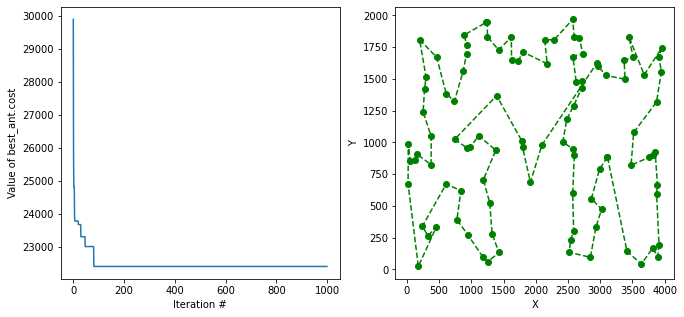

In [16]:
graph = Graph(x4, y4)

# creating eta matrix
with np.errstate(divide='ignore',invalid='ignore'):
    eta = 1/graph.edges
eta[eta == np.inf] = 0

# creating tau matrix
tau = np.full(eta.shape, 10/np.sum(graph.edges))

n_ants = graph.n
max_iter = 200
rho = 0.25
alpha = 1
beta = 4

best_ant, costs = run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta)
print('\nBest cost : ', best_ant.cost, 'for ', rho)
make_plots(costs, best_ant.tour, graph);